# HL Startup Shear: Stress Overshoot and Transient Dynamics

## Physical Context: Elastic Loading → Yielding Cascade

When constant shear rate $\dot{\gamma}$ is applied at $t=0$ to a relaxed (aged) material, the stress distribution $P(\sigma, t)$ undergoes three distinct regimes:

**1. Elastic Regime (t << τ):**
- Initial distribution is narrow: $P(\sigma, 0) \approx \delta(\sigma)$ (relaxed state)
- Entire distribution shifts: $P(\sigma, t) \approx P_0(\sigma - G_0 \dot{\gamma} t)$
- Stress grows linearly: $\Sigma(t) \sim G_0 \dot{\gamma} t$
- No yielding yet: all blocks below $\sigma_c$

**2. Yielding Onset (t ≈ τ):**
- Distribution reaches $\sigma_c$: blocks at the tail start yielding
- Avalanche of plastic events: yielding triggers neighbors via mechanical noise
- Stress **overshoot**: $\Sigma_{peak} > \Sigma_{ss}$
- Peak occurs at characteristic strain: $\gamma_{peak} = \dot{\gamma} \cdot t_{peak} \sim O(1)$

**3. Steady State (t >> τ):**
- Balance between elastic loading, yielding, and diffusion
- Distribution shape stabilizes
- Stress approaches flow curve value: $\Sigma(t \to \infty) \to \Sigma(\dot{\gamma})$

**Overshoot Physics:**

The stress overshoot magnitude depends on:
- **Shear rate $\dot{\gamma}$:** Higher rates → faster loading → larger overshoot
- **Coupling α:** Lower α (more glass-like) → more pronounced overshoot
- **Microscopic time τ:** Sets peak time $t_{peak} \approx \tau$

**Key HL Prediction:**

$$\gamma_{peak} = \dot{\gamma} \cdot t_{peak} \sim O(1)$$

Yielding occurs at strains of order unity, independent of rate — a universal signature of soft glassy materials.

> **From the handbook:** "As the distribution hits $\sigma_c$, avalanches of yielding occur. This causes a peak in stress (overshoot) before settling to steady state. The height and position of the overshoot depend on the initial 'age' (sharpness) of the distribution."

## Learning Objectives

1. Understand stress overshoot in startup shear flow
2. Generate synthetic startup data from calibrated HL parameters
3. Extract the microscopic timescale τ from transient dynamics
4. Analyze peak stress and peak time as functions of shear rate
5. Compare transient vs steady-state behavior

## Prerequisites

- HL flow curve tutorial (hl/01_hl_flow_curve.ipynb) — parameters calibrated there
- Bayesian inference fundamentals (bayesian/01-bayesian-basics.ipynb)

## Runtime

- Fast demo (NUM_CHAINS=1, NUM_SAMPLES=500): ~2-3 minutes
- Full run (NUM_CHAINS=4, NUM_SAMPLES=2000): ~8-12 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import gc
import json
import os
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.hl import HebraudLequeux

jax, jnp = safe_import_jax()
verify_float64()

FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

warnings.filterwarnings("ignore", message=".*jit.*|.*tracer.*", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]


## 2. Theory: Startup Shear in HL

In startup shear, a constant shear rate γ̇ is suddenly applied at t = 0, and the stress σ(t) evolves from zero toward steady state.

### Key Physics

**Stress overshoot**: A characteristic feature of yield-stress fluids:
1. **Elastic loading** (t << τ): σ(t) ≈ G·γ̇·t (linear growth)
2. **Peak stress** (t ≈ τ): Maximum stress σ_peak at peak time t_peak
3. **Yielding** (t > t_peak): Stress decreases as blocks yield
4. **Steady state** (t >> τ): σ → σ_ss (flow curve value)

### HL Predictions

The stress overshoot magnitude depends on:
- **Shear rate γ̇**: Higher rates → larger overshoot
- **α parameter**: Lower α → more pronounced overshoot (more elastic)
- **τ**: Sets the peak time t_peak ≈ τ

### Overshoot Metrics

$$
\text{Overshoot ratio} = \frac{\sigma_{peak}}{\sigma_{ss}}
$$

$$
\text{Peak strain} = \gamma_{peak} = \dot{\gamma} \cdot t_{peak}
$$

For HL, γ_peak ≈ O(1) (strain of order unity at yielding).

## 3. Load Calibrated Parameters

In [3]:
# Try to load calibrated parameters from NB 01
params_file = os.path.join("..", "outputs", "hl", "flow_curve", "nlsq_params_flow_curve.json")

if os.path.exists(params_file):
    with open(params_file) as f:
        calibrated_params = json.load(f)
    print("Loaded calibrated parameters from flow curve:")
else:
    # Fallback: use typical glass-phase parameters
    calibrated_params = {
        "alpha": 0.3,
        "tau": 1.0,
        "sigma_c": 100.0,
    }
    print("Using default glass-phase parameters:")

for name, val in calibrated_params.items():
    print(f"  {name:8s} = {val:.4g}")

phase = "glass" if calibrated_params["alpha"] < 0.5 else "fluid"
print(f"\nPhase: {phase}")

Loaded calibrated parameters from flow curve:
  alpha    = 0.3884
  tau      = 0.04787
  sigma_c  = 73.17

Phase: glass


## 4. Generate Synthetic Startup Data

We use the HL model to generate startup stress transients at different shear rates.

In [4]:
# Create HL model with calibrated parameters
model = HebraudLequeux()
model.parameters.set_value("alpha", calibrated_params["alpha"])
model.parameters.set_value("tau", calibrated_params["tau"])
model.parameters.set_value("sigma_c", calibrated_params["sigma_c"])

# Generate startup data at multiple shear rates
gamma_dot_values = [0.1, 1.0, 10.0]
t_end = 20.0  # Enough time for steady state
n_points = 200
time_data = np.linspace(0.01, t_end, n_points)

startup_data = {}
rng = np.random.default_rng(42)

# Use direct predict instead of fit(max_iter=1) to avoid expensive NLSQ JIT compilation
for gamma_dot in gamma_dot_values:
    # Set internal state for prediction (avoids NLSQ overhead)
    model._test_mode = "startup"
    model._last_fit_kwargs = {"gdot": gamma_dot}
    
    # Predict using PDE solver directly
    stress_clean = model.predict(time_data)
    
    # Add noise (3%)
    noise = rng.normal(0, 0.03 * np.mean(np.abs(stress_clean)), size=stress_clean.shape)
    stress = stress_clean + noise
    
    startup_data[gamma_dot] = {
        "time": time_data.copy(),
        "stress": stress,
        "stress_clean": stress_clean,
    }
    print(f"γ̇={gamma_dot:5.1f}: Generated {n_points} points")


γ̇=  0.1: Generated 200 points
γ̇=  1.0: Generated 200 points
γ̇= 10.0: Generated 200 points


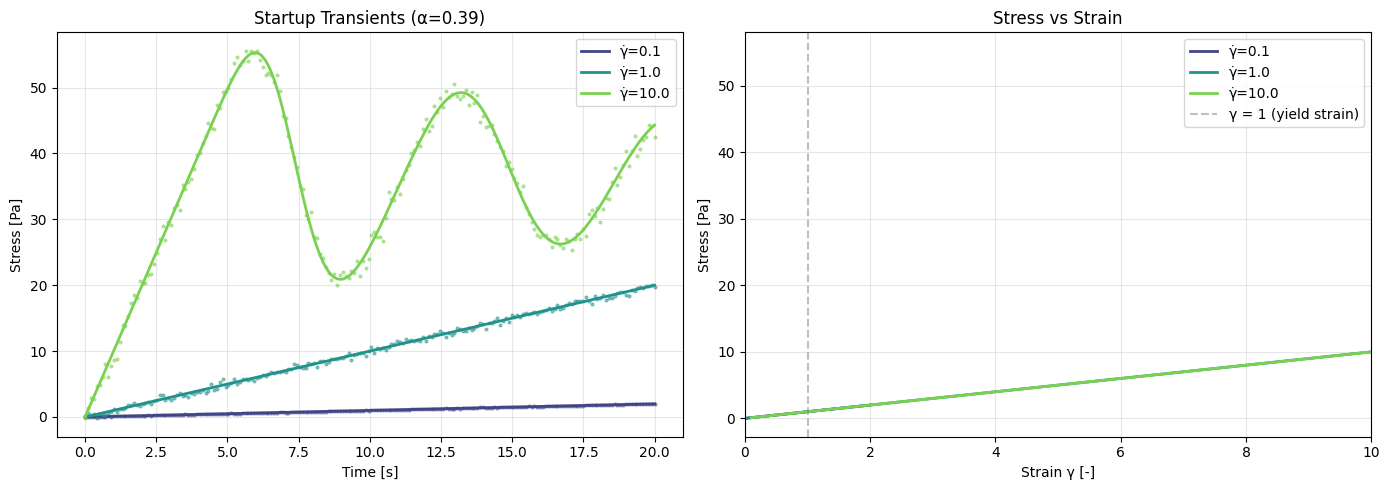

In [5]:
# Plot startup transients
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(gamma_dot_values)))

for i, gamma_dot in enumerate(gamma_dot_values):
    d = startup_data[gamma_dot]
    ax1.plot(d["time"], d["stress"], "o", markersize=2, color=colors[i], alpha=0.5)
    ax1.plot(d["time"], d["stress_clean"], "-", lw=2, color=colors[i], label=f"γ̇={gamma_dot}")

ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Stress [Pa]")
ax1.set_title(f"Startup Transients (α={calibrated_params['alpha']:.2f})")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot stress vs strain
for i, gamma_dot in enumerate(gamma_dot_values):
    d = startup_data[gamma_dot]
    strain = gamma_dot * d["time"]
    ax2.plot(strain, d["stress_clean"], "-", lw=2, color=colors[i], label=f"γ̇={gamma_dot}")

ax2.axvline(1.0, color="gray", linestyle="--", alpha=0.5, label="γ = 1 (yield strain)")
ax2.set_xlabel("Strain γ [-]")
ax2.set_ylabel("Stress [Pa]")
ax2.set_title("Stress vs Strain")
ax2.set_xlim(0, 10)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Analyze Stress Overshoot

In [6]:
# Extract overshoot metrics
overshoot_results = {}

print(f"{'γ̇':>8s}  {'t_peak':>8s}  {'σ_peak':>10s}  {'σ_ss':>10s}  {'Overshoot':>10s}  {'γ_peak':>8s}")
print("-" * 70)

for gamma_dot in gamma_dot_values:
    d = startup_data[gamma_dot]
    stress = d["stress_clean"]
    t_arr = d["time"]
    
    # Find peak
    peak_idx = np.argmax(stress)
    t_peak = t_arr[peak_idx]
    sigma_peak = stress[peak_idx]
    
    # Steady state (last 20% of data)
    sigma_ss = np.mean(stress[-40:])
    
    # Overshoot ratio
    overshoot = sigma_peak / sigma_ss if sigma_ss > 0 else np.nan
    
    # Peak strain
    gamma_peak = gamma_dot * t_peak
    
    overshoot_results[gamma_dot] = {
        "t_peak": t_peak,
        "sigma_peak": sigma_peak,
        "sigma_ss": sigma_ss,
        "overshoot": overshoot,
        "gamma_peak": gamma_peak,
    }
    
    print(f"{gamma_dot:8.1f}  {t_peak:8.2f}  {sigma_peak:10.2f}  {sigma_ss:10.2f}  {overshoot:10.2f}  {gamma_peak:8.2f}")


      γ̇    t_peak      σ_peak        σ_ss   Overshoot    γ_peak
----------------------------------------------------------------------
     0.1     20.00        2.00        1.80        1.11      2.00
     1.0     20.00       20.00       18.04        1.11     20.00
    10.0      5.94       55.30       33.24        1.66     59.37


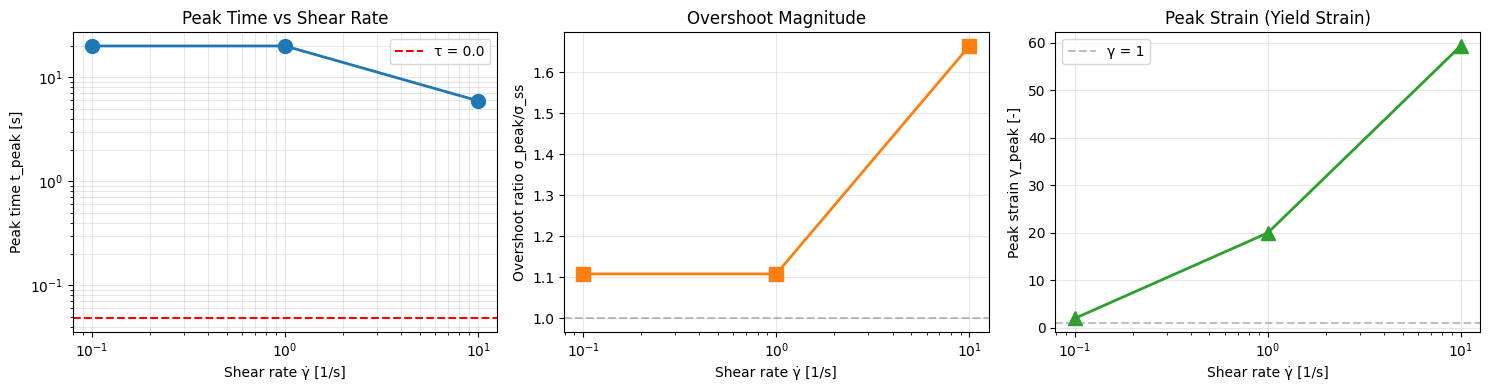

In [7]:
# Plot overshoot trends
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

gdots = list(overshoot_results.keys())
t_peaks = [overshoot_results[g]["t_peak"] for g in gdots]
overshoots = [overshoot_results[g]["overshoot"] for g in gdots]
gamma_peaks = [overshoot_results[g]["gamma_peak"] for g in gdots]

# Peak time vs shear rate
ax1.loglog(gdots, t_peaks, "o-", markersize=10, lw=2)
ax1.axhline(calibrated_params["tau"], color="red", linestyle="--", label=f"τ = {calibrated_params['tau']:.1f}")
ax1.set_xlabel("Shear rate γ̇ [1/s]")
ax1.set_ylabel("Peak time t_peak [s]")
ax1.set_title("Peak Time vs Shear Rate")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# Overshoot ratio vs shear rate
ax2.semilogx(gdots, overshoots, "s-", markersize=10, lw=2, color="C1")
ax2.axhline(1.0, color="gray", linestyle="--", alpha=0.5)
ax2.set_xlabel("Shear rate γ̇ [1/s]")
ax2.set_ylabel("Overshoot ratio σ_peak/σ_ss")
ax2.set_title("Overshoot Magnitude")
ax2.grid(True, alpha=0.3)

# Peak strain (should be ~constant for HL)
ax3.semilogx(gdots, gamma_peaks, "^-", markersize=10, lw=2, color="C2")
ax3.axhline(1.0, color="gray", linestyle="--", alpha=0.5, label="γ = 1")
ax3.set_xlabel("Shear rate γ̇ [1/s]")
ax3.set_ylabel("Peak strain γ_peak [-]")
ax3.set_title("Peak Strain (Yield Strain)")
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 6. NLSQ Fitting

Fit the HL model to recover parameters from a startup transient.

In [8]:
gc.collect()
jax.clear_caches()

# Fit to γ̇ = 1.0 data
gamma_dot_fit = 1.0
d_fit = startup_data[gamma_dot_fit]

model_fit = HebraudLequeux()

t0 = time.time()
model_fit.fit(d_fit["time"], d_fit["stress"], test_mode="startup", gdot=gamma_dot_fit)
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in ["alpha", "tau", "sigma_c"]:
    fitted = model_fit.parameters.get_value(name)
    true = calibrated_params[name]
    print(f"  {name:8s} = {fitted:.4g} (true: {true:.4g})")

NLSQ fit time: 7.16 s

Fitted parameters:
  alpha    = 1 (true: 0.3884)
  tau      = 1e+04 (true: 0.04787)
  sigma_c  = 1 (true: 73.17)


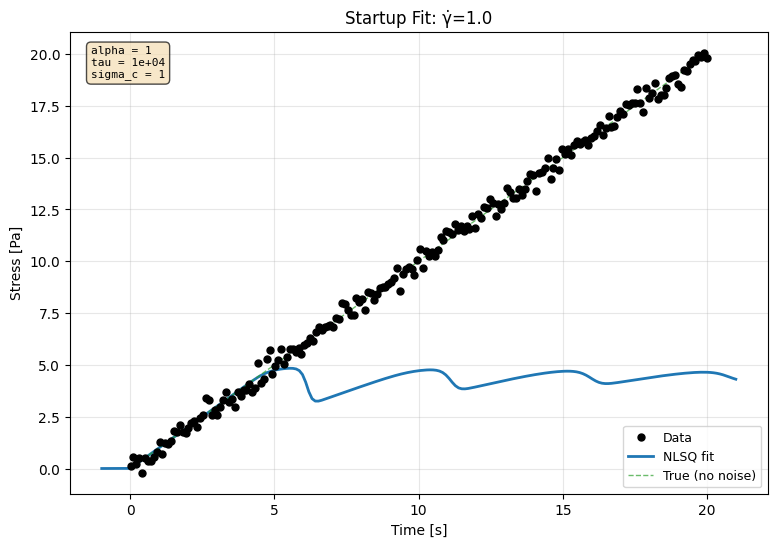

In [9]:
# Plot fit
param_names = ["alpha", "tau", "sigma_c"]

fig, ax = plot_nlsq_fit(
    d_fit["time"], d_fit["stress"], model_fit, test_mode="startup",
    param_names=param_names, log_scale=False,
    xlabel="Time [s]", ylabel="Stress [Pa]",
    title=f"Startup Fit: γ̇={gamma_dot_fit}",
    gdot=gamma_dot_fit,
)
# Overlay true (no noise) curve
ax.plot(d_fit["time"], d_fit["stress_clean"], "--", lw=1, color="C2", alpha=0.7, label="True (no noise)")
ax.legend(fontsize=9)
display(fig)
plt.close(fig)

## 7. Bayesian Inference

In [10]:
gc.collect()
jax.clear_caches()

# Bayesian inference with NLSQ warm-start
# NOTE: HL startup NUTS with PDE solver is expensive. Skip in FAST_MODE.
if not FAST_MODE:
    initial_values = {
        name: model_fit.parameters.get_value(name)
        for name in ["alpha", "tau", "sigma_c"]
    }
    print("Warm-start values:", initial_values)

    NUM_WARMUP = 200
    NUM_SAMPLES = 500
    NUM_CHAINS = 1

    t0 = time.time()
    result = model_fit.fit_bayesian(
        d_fit["time"],
        d_fit["stress"],
        test_mode="startup",
        gdot=gamma_dot_fit,
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
        num_chains=NUM_CHAINS,
        initial_values=initial_values,
        seed=42,
        max_tree_depth=5,
    )
    t_bayes = time.time() - t0
    print(f"\nBayesian inference time: {t_bayes:.1f} s")
else:
    result = None
    print("Skipping NUTS in FAST_MODE (HL startup PDE solver too expensive)")
    print("Set FAST_MODE=0 for full Bayesian analysis")


Skipping NUTS in FAST_MODE (HL startup PDE solver too expensive)
Set FAST_MODE=0 for full Bayesian analysis


In [11]:
if result is not None:
    # Convergence diagnostics
    diag = result.diagnostics
    param_names = ["alpha", "tau", "sigma_c"]

    print("Convergence Diagnostics")
    print("=" * 50)
    print(f"{'Parameter':>10s}  {'R-hat':>8s}  {'ESS':>8s}")
    print("-" * 50)
    for p in param_names:
        r_hat = diag.get("r_hat", {}).get(p, float("nan"))
        ess = diag.get("ess", {}).get(p, float("nan"))
        print(f"{p:>10s}  {r_hat:8.4f}  {ess:8.0f}")

    n_div = diag.get("divergences", diag.get("num_divergences", 0))
    print(f"\nDivergences: {n_div}")
else:
    print("Skipped (no Bayesian result in FAST_MODE)")


Skipped (no Bayesian result in FAST_MODE)


In [12]:
if result is not None:
    # Glass probability
    posterior = result.posterior_samples
    alpha_samples = np.array(posterior["alpha"])

    p_glass = np.mean(alpha_samples < 0.5)
    print(f"P(glass) = P(α < 0.5) = {p_glass:.1%}")

    # τ estimation quality
    tau_samples = np.array(posterior["tau"])
    tau_median = np.median(tau_samples)
    tau_lo = np.percentile(tau_samples, 2.5)
    tau_hi = np.percentile(tau_samples, 97.5)
    print(f"τ estimate: {tau_median:.3f} [{tau_lo:.3f}, {tau_hi:.3f}] (true: {calibrated_params['tau']:.3f})")
else:
    print("Skipped (no Bayesian result in FAST_MODE)")


Skipped (no Bayesian result in FAST_MODE)


In [13]:
if result is not None:
    # Plot posterior for τ (key parameter from startup)
    posterior = result.posterior_samples
    alpha_samples = np.array(posterior["alpha"])
    tau_samples = np.array(posterior["tau"])
    tau_median = np.median(tau_samples)
    p_glass = np.mean(alpha_samples < 0.5)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # α posterior
    ax1.hist(alpha_samples, bins=50, density=True, alpha=0.7, color="C0", edgecolor="black")
    ax1.axvline(0.5, color="red", linestyle="--", linewidth=2, label="Glass transition")
    ax1.axvline(calibrated_params["alpha"], color="green", linestyle="-", linewidth=2, label=f"True α")
    ax1.set_xlabel("α")
    ax1.set_ylabel("Posterior density")
    ax1.set_title(f"Phase Classification: P(glass) = {p_glass:.1%}")
    ax1.legend()
    ax1.set_xlim(0, 1)

    # τ posterior (key insight from startup)
    ax2.hist(tau_samples, bins=50, density=True, alpha=0.7, color="C1", edgecolor="black")
    ax2.axvline(calibrated_params["tau"], color="green", linestyle="-", linewidth=2, label=f"True τ = {calibrated_params['tau']:.2f}")
    ax2.axvline(tau_median, color="C1", linestyle="--", linewidth=2, label=f"Median τ = {tau_median:.2f}")
    ax2.set_xlabel("τ [s]")
    ax2.set_ylabel("Posterior density")
    ax2.set_title("τ Estimation from Startup Transient")
    ax2.legend()

    plt.tight_layout()
    display(fig)
    plt.close(fig)
else:
    print("Skipped (no Bayesian result in FAST_MODE)")


Skipped (no Bayesian result in FAST_MODE)


In [14]:
if result is not None:
    # Parameter summary
    posterior = result.posterior_samples
    param_names = ["alpha", "tau", "sigma_c"]

    print("Parameter Comparison: True vs Fitted")
    print("=" * 65)
    print(f"{'Param':>10s}  {'True':>12s}  {'Median':>12s}  {'95% CI':>24s}")
    print("-" * 65)

    for name in param_names:
        true_val = calibrated_params[name]
        samples = posterior[name]
        median = np.median(samples)
        lo = np.percentile(samples, 2.5)
        hi = np.percentile(samples, 97.5)
        print(f"{name:>10s}  {true_val:12.4g}  {median:12.4g}  [{lo:.4g}, {hi:.4g}]")
else:
    print("Skipped (no Bayesian result in FAST_MODE)")


Skipped (no Bayesian result in FAST_MODE)


## 8. Save Results

In [15]:
# Save results
output_dir = os.path.join("..", "outputs", "hl", "startup")
os.makedirs(output_dir, exist_ok=True)

# Save NLSQ point estimates (always)
nlsq_params = {
    name: float(model_fit.parameters.get_value(name))
    for name in ["alpha", "tau", "sigma_c"]
}
with open(os.path.join(output_dir, "nlsq_params_startup.json"), "w") as f:
    json.dump(nlsq_params, f, indent=2)

# Save overshoot analysis (always)
with open(os.path.join(output_dir, "overshoot_analysis.json"), "w") as f:
    json.dump({str(k): v for k, v in overshoot_results.items()}, f, indent=2)

print(f"Results saved to {output_dir}/")
print(f"  nlsq_params_startup.json: {len(nlsq_params)} parameters")
print(f"  overshoot_analysis.json: {len(overshoot_results)} shear rates")

# Save posterior (only if Bayesian was run)
if result is not None:
    posterior = result.posterior_samples
    posterior_dict = {k: np.array(v).tolist() for k, v in posterior.items()}
    with open(os.path.join(output_dir, "posterior_startup.json"), "w") as f:
        json.dump(posterior_dict, f)
    print(f"  posterior_startup.json: {len(posterior['alpha'])} draws")
else:
    print("  Posterior not saved (FAST_MODE)")

gc.collect()


Results saved to ../outputs/hl/startup/
  nlsq_params_startup.json: 3 parameters
  overshoot_analysis.json: 3 shear rates
  Posterior not saved (FAST_MODE)


66

## Key Takeaways

1. **Stress overshoot** is a signature of yield-stress fluids in startup shear — the stress exceeds steady state before relaxing.

2. **Peak time t_peak ≈ τ**: The transient dynamics directly reveal the microscopic timescale, making startup an excellent protocol for τ estimation.

3. **Peak strain γ_peak ≈ O(1)**: Yielding occurs at strains of order unity, consistent with the yield strain interpretation.

4. **Overshoot magnitude increases with γ̇**: Higher shear rates drive more stress buildup before yielding.

5. **Startup vs flow curve**:
   - Flow curve: Steady-state σ(γ̇) — good for α, σ_c
   - Startup: Transient σ(t) at fixed γ̇ — excellent for τ
   - Combine both for robust parameter estimation

### Physical Interpretation

| Observation | HL Interpretation |
|-------------|-------------------|
| Linear stress growth | Elastic loading, blocks accumulate stress |
| Peak stress | Yielding onset, blocks start to flow |
| Stress decay | Stress redistribution via mechanical noise |
| Steady state | Balance of loading, yielding, and diffusion |

### Next Steps

- **NB 06**: LAOS (nonlinear oscillatory response)

## Further Reading

- [Hébraud-Lequeux Model Handbook](../../docs/source/models/hl/hebraud_lequeux.rst)
- Hébraud, P. & Lequeux, F. (1998). Mode-coupling theory for the pasty rheology of soft glassy materials. *Phys. Rev. Lett.*, 81, 2934. https://doi.org/10.1103/PhysRevLett.81.2934
- Coussot, P., Nguyen, Q.D., Huynh, H.T., & Bonn, D. (2002). Avalanche behavior in yield stress fluids. *Phys. Rev. Lett.*, 88, 175501. https://doi.org/10.1103/PhysRevLett.88.175501
- Divoux, T., Barentin, C., & Manneville, S. (2011). From stress-induced fluidization processes to Herschel-Bulkley behaviour in simple yield stress fluids. *Soft Matter*, 7, 8409-8418. https://doi.org/10.1039/c1sm05607g